## Import modules

In [1]:
import os, requests
from matplotlib import rcParams
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
import random
import warnings
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import Ridge
from scipy.ndimage import gaussian_filter1d, generic_filter1d, correlate1d
from scipy.stats import halfnorm
from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from datetime import date

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Loading of Steinmetz data

includes some visualizations

In [2]:
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Own analysis



#### Inputs:

1. Time-course of stimulation, where the stimulus is only on one side of the visual field or neither one

2. Time-course of the behavioral response

3. Time-course of detection

4. Binned (10 ms) firing rate from each neuron recorded across trials within these trial types.

5. Location of each neuron (brain-region).

### Outputs:
	
- Models: General output: Binned firing rate

- One model with all components (1-5)

- For final analysis: One model without detection component (1,2,4,5) 

- For testing: also one model without stimulation component (1) and one model without response component (2)




# Designing the model

X*(F, Neurons) = [array]
array.shape(Neurons, n_frames)

# Functions

In [3]:
##### Random seed given
random.seed(42)

def get_last_valid_trial(session_data):
  """returns index of last valid trial in which the animal did respond during a visible stimulus"""
  data_choice = pd.Series(create_choice_data(session_data, inc_side='right'), name = 'choice')
  right_side = pd.Series(session_data['contrast_right'], name = 'right')
  left_side = pd.Series(session_data['contrast_left'], name = 'left')
  df = pd.concat([data_choice, right_side, left_side], axis=1)
  last_index = df[(df['choice'] != 0) & (df['right'] != 0) | (df['choice'] != 0) & (df['left'] != 0)].index.values[-1]
  return last_index

def select_contrast_100(session_data, included_side):

  #leave this as is:
  excluded_side = 'right' if included_side == 'left' else 'left'

  #looking at contrast levels per side to select a number of side-specific trials where the other side has contrast level "0"
  right_side = pd.Series(session_data['contrast_right'], name = 'right')
  left_side = pd.Series(session_data['contrast_left'], name = 'left')
  data_contrast = pd.concat([right_side, left_side], axis=1)
  # this includes 0,0 sessions!
  data_contrast_one_side = data_contrast[data_contrast[excluded_side] == 0]
  #change this!
  data_contrast_one_side = data_contrast[data_contrast[included_side] == 1]
  # select index to get trials
  index_contrast_one = data_contrast_one_side.index.values

  return  index_contrast_one


def select_side(session_data, included_side, shuffle = False ,report = False):
  """filters trials for sessions including the selected side for contrast with the other side being 0. 
  Also limits the trials to the last valid trial in which the animal responded to a visible contrast regardless of side."""

  last_valid_index = get_last_valid_trial(session_data)

  #leave this as is:
  excluded_side = 'right' if included_side == 'left' else 'left'
  if report:
    print(f'Selected side: {included_side}', f'Excluded: {excluded_side}')

  #looking at contrast levels per side to select a number of side-specific trials where the other side has contrast level "0"
  right_side = pd.Series(session_data['contrast_right'], name = 'right')
  left_side = pd.Series(session_data['contrast_left'], name = 'left')
  data_contrast = pd.concat([right_side, left_side], axis=1)
  # this includes 0,0 sessions!
  # select index to get trials
  index_contrast_one = data_contrast[data_contrast[excluded_side] == 0].index.values

  #take only indexes smaller than last valid index
  index_contrast_last_valid = np.array([idx for idx in index_contrast_one if idx <= last_valid_index])

  #reselect all trials based on this
  data_contrast_last_valid = data_contrast.loc[index_contrast_last_valid]

  if report:
    print(f'Total Number of trials with this side: {index_contrast_one.size}\n',
          f'Last valid index {last_valid_index}.\n',
          f'Resulting cut off: {index_contrast_one.size - index_contrast_last_valid.size}')

  #Reindex for subselection
  data_side_one = data_contrast_last_valid.copy().reset_index(drop = True)

  if shuffle:
    """TODO: add shuffle"""
    pass

  return  index_contrast_last_valid, data_side_one


def select_brain_region(session, brain_regions:list):
  """Filtering neurons based on brain region input
  :param list or str brain_regions: which brain regions should be exclusively used for neuron selection.
  :returns index of neurons in the specified brain regions. If "all" returns full index"""
  if brain_regions == "all":
     idx_location_subset = np.arange(0, session['brain_area'].size)
  else:
    location = session['brain_area']
    idx_location_subset = np.argwhere(np.in1d(location, brain_regions)).flatten()

  return idx_location_subset


def select_neurons(recordings, idx_location_subset = None, index_trial_subset = None, filter_width = None, filter_type = None, zscore_thresh = 2):
  """Selects neurons in recordings based on their z-score during the visual stimulus period.
   Z-score is calculated by taking baseline activity into account before the stimulus.
   For this, neurons that were not active during baseline, but active during the stimulus have a z-score of np.inf (which is greater 2),
   while neurons that were not active in both cases, have a z-score of np.NaN (which are filtered out).
   The function preselects neurons based on the brain region selection with idx_location_subset and only considers trials selected by
   index_trial_subset

   :return np.Array included_idx: Index of recordings where absolute neuronal activity z-score was greater than 2 compared to baseline
   """

  # note - in the future, only use trials where 100 contrast was given
  included_idx = []

  #if no location was given, select all neurons
  if idx_location_subset is None:
    idx_location_subset = recordings.shape[0]

  #if no trial subset was given, select all trials
  if index_trial_subset is None:
    index_trial_subset = recordings.shape[1] 


  for neuron_idx in idx_location_subset:

    if filter_width is not None and filter_type is not None:
      smoothed = smooth_spikes(recordings[neuron_idx,:,:], filter_width, filter_type)

    smoothed = recordings[neuron_idx,index_trial_subset,:]

    baselines = np.mean(smoothed[:,40:50],axis=1) # the baselines, -100-0 ms to stim
    mean_response = np.mean(smoothed[:,50:70]) # mean neural activity 0-250 ms post-stim

    z_score = (mean_response - np.mean(baselines))/np.std(baselines)
    
    if abs(z_score) > zscore_thresh:

      included_idx.append(neuron_idx)

    

  return np.array(included_idx)


def select_dynamic_trial_ends(session, subselect_index = None, buffer = 0):
  """selects response times per trial and returns them as dynamic trial end
   aka rounded binned value to use for indexing.
   :param session data from one session
   :param float/int or np.Array buffer: array with size subselect_index or float/int to correct response time
   e.g. to correct for go cue timing or vis stim onset if not included. Default 0
   :param np.Array subselect_index: 1d array with indexes to subselect session trials. Default None.
   If none includes all trials in session"""
  if subselect_index is None:
    response_times = session['response_time'].copy().flatten()
  else:
    response_times = session['response_time'][subselect_index].copy().flatten()

  return np.round(response_times/0.1).astype(int) + 50



In [4]:
def create_regressor(data, index_0, window: tuple, trial_windows):
  """ Creates regressor matrix for creation of design matrix with shape (trial_len*data.size, window_len)"""

  def check_index(index):
    """checks if index is an iterable or a single element"""
    try:
      iterator = iter(index)
    
      return True
    except TypeError:
        return False

  #print(trial_windows)

  trial_len = trial_windows[:, 1] - trial_windows[:, 0]
  multi_index = check_index(index_0)
  window_len = window[1] - window[0]
  matrix_len = np.sum(trial_len)
  #print(matrix_len)
  # check potential errors!
  if multi_index and len(index_0) != data.size:
    raise ValueError(f'Index needs to be size of the data {data.size}, but is {len(index_0)}')
  
  #create empty matrix with "0"
  regressor = np.zeros((matrix_len, window_len))
  #calculate all trial start indices
  #trial_starts = np.arange(0, matrix_len, trial_len)
  #calculate dynamic trial starts
  trial_starts = np.cumsum(trial_len, axis= 0) - trial_len[0]

  #print(trial_starts, matrix_len)
  #print(trial_starts.shape)
  #select each window start by adding the window start index to all elements

  for trial_num, trial_strt in enumerate(trial_starts):
    if multi_index:
      #if trial window is cut at the front adjust index accordingly
      index = index_0[trial_num] - trial_windows[trial_num, 0]
    else:
      index = index_0 - trial_windows[trial_num, 0]
    if index < 0:
      #print('Skipping negativ index...', index)
      pass
    else:
      window_start = index + window[0]
      #select window start for current trial 
      position_one = trial_strt + window_start
      #take value from data 
      reg_value = data[trial_num]
      #print(trial_num, index, position_one,  reg_value)
      #loop through the shifting window by 1 and set the current position
      #print(f'Trial {trial_num}, position one {position_one}, reg_val {reg_value}')
      for window_pos in range(0, window_len):
        current_pos = position_one + window_pos
        if current_pos >= trial_strt + trial_len[trial_num]:
          #print('Oh Oh! This one goes over the trial. At position {}, trial {}'.format(current_pos, trial_num))
          break
        elif current_pos >= matrix_len:
          #print('Oh Oh! This one goes over the matrix. At position {}, trial {}'.format(current_pos, trial_num))
          break
        elif current_pos < trial_strt:
          # if the window is starting before the trial window (this happens when the trial window is cut in front to smaller than index - window[0])
          # these will be ignored, effectively cutting off the window
          pass
        else:
          regressor[current_pos, window_pos] = reg_value

  return regressor


def create_vis_regressor(data_side_one, contrast_list, trial_windows, index_vis_0 = 50, window_vis = ( - 5, 40),  report = False, shuffle = False,):
  random.seed(42)
  visreg_dict ={}
    # save all trial indices that where excluded side 0 and included side equal to selected contrast side.
  if shuffle:

    data_included_side = data_side_one[included_side].copy()
    random.shuffle(data_included_side) 

  else:

    data_included_side = data_side_one[included_side]

  for contrast_level in contrast_list:
    #data = data_contrast[(data_contrast[excluded_side] == 0) & (data_contrast[included_side] == contrast_level)]
    data = data_included_side[(data_included_side == contrast_level)]
    
    index = data.index.values
    
    visreg_dict[contrast_level] = dict(index = index)
    if report:
      print(f'Number of trials with contrast level {contrast_level}: {index.size}')
    # print('\n Example extract: \n', data[:5])
    # print(data_side_one.shape)

  #go through all contrast levels and create the vision regressor for the design matrix
  for contrast_level in contrast_list:
    # get indices from dict
    index_vis = visreg_dict[contrast_level]['index']
    vis_data = np.zeros(data_included_side.shape[0])
    vis_data[index_vis] = 1
    # create vision regr with function
    vision_regr = create_regressor(vis_data, index_vis_0, window_vis, trial_windows)
    #add vision regressor to matrix dictionary 
    visreg_dict[contrast_level]['vis_regressor'] = vision_regr
    # print(f'Vision regressor for {contrast_level} contrast has shape {vision_regr.shape}.')
    # print('Vision data  extract: ', vis_data[:10])

  return visreg_dict


def create_choice_data(session_data, inc_side, index_trial_subselect = None, shuffle = False):
  random.seed(42)
  #if choice correct side 1, wrong side -1, no choice 0 side corrected version of session_data['response']
  side_coding = dict(left = 1, right = -1)
  #unify independent of sides: correct +1, wrong -1, no go 0
  if index_trial_subselect is None:
    index_trial_subselect = np.arange(session_data['response'].size)

  if inc_side == 'left':
    #already right 
    choice_data = session_data['response'][index_trial_subselect].copy()
  elif inc_side == 'right':
    #if it's right flip it
    # this leaves a weird -0.0 value (but we can ignore it)
    choice_data = session_data['response'][index_trial_subselect].copy() * -1
  else:
    raise ValueError(f'Included Side can either be "left" or "right", not {inc_side}')

  if shuffle:
    # copy, then shuffle the data
    choice_data_shuffled = choice_data.copy()
    random.shuffle(choice_data_shuffled)

    return choice_data_shuffled

  else:
    # don't shuffle the data
    return choice_data
  


def create_design_matrix(dat, included_side: str, trial_window: tuple = (0, 250),
                         regr_list: list = ['vision', 'choice', 'action', 'detection'],
                         include_constant: bool = True,
                         dynamic_trial_window: bool = True,
                         report = False,
                         shuffle = False):
  """Creates design matrix X based on regression windows
  :param np.Array dat: Input data (session) from Steinmetz dataset. Side selection is done automatically
  :param str included_side: which side of contrast stimulus to consider.'right' or 'left'
  :param tuple trial_window: tuple in style (int, int) with trial window start and end.
  :param list regr_list: List of regressors to include (ORDER MATTERS!).
   Default: ['vision', 'choice', 'action', 'detection']
  :param bool include_constant: If constant should be included. Default: True
  :param bool dynamic_trial_window: If dynamic_trial_window should be used. This will set the window end to the reponse time of each trial.
  Default: True
  :param bool report: toggle reporting prints during design matrix creation; default False
  :param bool shuffle: toggle shuffling of choice and visual data used to create design matrix
  """
  regr_dict = {}
  
  # change this again!
  contrast_list = [0.25, 0.5, 1.0]

  index_contrast_one, data_side_one = select_side(dat, included_side, report= report)

  if dynamic_trial_window:
    dynamic_trial_ends = select_dynamic_trial_ends(dat, index_contrast_one)
    #create dynamic trial windows, this overwrites any manual restriction of the trial end!
    #trial start can still be set
    dynamic_trial_window = np.full((dynamic_trial_ends.size,2), trial_window)
    dynamic_trial_window[:,1] = dynamic_trial_ends
    trial_windows = dynamic_trial_window
  
  else:
    trial_windows = np.full((index_contrast_one.size,2), trial_window)

  if 'vision' in regr_list:
    index_vis_0 = 50
    window_vis = ( - 5, 40)
    if report:
      print('Creating vision regressor...')
    visreg_dict = create_vis_regressor(data_side_one, contrast_list, trial_windows, index_vis_0, window_vis, report = report, shuffle = shuffle)
 
  if 'choice' in regr_list:
    ## choice
    # same index in action as in choice
    # index_cho_0 = dat['response_time'][index_contrast_one].copy().flatten()
    index_cho_0 = dat['reaction_time'][index_contrast_one, 0].copy().flatten()
    #set all inf values outside of range to be filtered
    index_cho_0[index_cho_0 == float('+inf')] = -1000
    index_cho_0 = np.round((index_cho_0+500)/10).astype(int)

    window_cho = (- 25, 3)
    choice_data = create_choice_data(dat, included_side, index_contrast_one, shuffle = shuffle)
    #print(choice_data.shape)
    if report:
      print('Creating choice regressor...')
    cho_regressor = create_regressor(choice_data, index_cho_0, window_cho, trial_windows)
    regr_dict['choice'] = cho_regressor

  if 'action' in regr_list:

    window_act = (- 25, 3)
    # same index in action as in choice
    if 'choice' in regr_list:
      index_act_0 = index_cho_0
      #set all non zero values to 1
      action_data = choice_data.copy()
      action_data[choice_data != 0] = 1
    else:
      ## action
      action_data = create_choice_data(dat, included_side, index_contrast_one, shuffle = shuffle)
      #set all non zero values to 1
      action_data[action_data != 0] = 1
      # index_act_0 = dat['response_time'][index_contrast_one].copy().flatten()
      index_act_0 = dat['reaction_time'][index_contrast_one, 0].copy().flatten()
      #set all inf values outside of range to be filtered
      index_act_0[index_act_0 == float('+inf')] = -1000
      index_act_0 = np.round((index_act_0+500)/10).astype(int)
    if report:
      print('Creating action regressor...') 
    act_regressor = create_regressor(action_data, index_act_0, window_act, trial_windows)
    regr_dict['action'] = act_regressor

  if 'detection' in regr_list:
    ## detection
    index_det_0 = 50
    window_det = ( - 5, 40) # for vision

    #all contrast levels except 0,0 for side:
    detection_data_vis = data_side_one[(data_side_one[included_side] != 0)].index.values
    #preallocating detection data array 
    if not 'choice' in regr_list:
      choice_data = create_choice_data(dat, included_side, index_contrast_one, shuffle = shuffle)
    detection_data = np.zeros_like(choice_data)

    # comparing with choice data at same trial
    for idx in detection_data_vis:      
        # if vis and choice data is 1 =1 else 0
        detection_data[idx] = 1 if choice_data[idx] == 1 else 0

    if report:
      print('Creating detection regressor...')
    det_regressor = create_regressor(detection_data, index_det_0, window_det, trial_windows)
    regr_dict['detection'] = det_regressor
  
  #merge all regressors
  if report:
    print('Merging regressors...')
  if 'vision' in regr_list:
    vision_regr = None
    for contrast_level in contrast_list:
      #print(contrast_level)
      vision_regr_sub = visreg_dict[contrast_level]['vis_regressor']
      if vision_regr is None:
        vision_regr = vision_regr_sub
      else:
        vision_regr = np.concatenate((vision_regr, vision_regr_sub), axis = 1)

    regr_dict['vision'] = vision_regr

  #X_design_old = np.concatenate((vision_regr, cho_regressor, act_regressor, det_regressor))

  #merge all regressors
  X_design = np.concatenate([ regr_dict[k] for k in regr_list], axis = 1)

  if include_constant:
    # # Build the full design matrix
    constant = np.ones((X_design.shape[0], 1))
    X_design = np.hstack((X_design, constant))
    

  if report:
    print('X_design with shape ', X_design.shape)

  return X_design, index_contrast_one

In [5]:
# @title visualization function
def visualize_X_design(X_design, trial_window):
  # Design matrix visualization (may need resizing depending on data range)
  len_trial = trial_window[1] - trial_window[0]
  data_range = (0, X_design.shape[0])
  fig = plt.figure(figsize=(200, 300))
  plt.imshow(X_design.T[:,data_range[0]:data_range[1]], cmap = 'seismic', interpolation= None, vmin=-1, vmax=1)

  # the axline plots are not working with reduced design matrixes

  for x in range(0, X_design.shape[0], len_trial):
    plt.axvline(x)
    #stim onset :)
    plt.axvline(x+50 - trial_window[0] , color= 'k', linestyle='--')
  #vision regressors
  for x in range(4):
    plt.axhline(45*x)
  # other regressors
  plt.axhline(28+x*45)
  plt.axhline(28*2+x*45)

  #plt.xticks(range(0 + int(len_trial/2), X_design.shape[0] + int(len_trial/2), len_trial), [f'Trial {x}' for x in index_trial_subselect] )
  plt.xlabel('Trials')
  plt.ylabel('Regressors')
  #plt.xlim(0, 5000)
  plt.ylim(0, X_design.shape[1])

  print('Data range: ', data_range)

  return fig

## Pipeline

1. Set Parameters!
2. Mount google drive to save data to it!
3. Run code!

In [6]:
"""Set up"""
#which brain regions to include:
# all selects all brain regions
# can be list of strings or single string
#['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam', 'VISp', 'root']

brain_regions = 'all'

#trial window can be set freely.
trial_window = (45, 90)
#this will overwrite the end of the trial window (not the start) with the response time for each trial
#function is not yet implemented into for loop going through neurons
dynamic_trial_window = False

#filter for spike smoothing
filter_width = 2.5

# what type of filter to use for spike count smoothing.
# can be half_gauss or full_gauss
filter_type = 'half_gauss'

#which side of visual contrast to include
included_side = 'right'

#whether to include detection regressor or constant
include_constant = False


In [7]:
# #@title Cross validation function for neurons
def halfnorm_filter1d(input, sigma, axis=-1, output=None,
                      mode="reflect", cval=0.0, truncate=4.0):
    """Custom version of https://github.com/scipy/scipy/blob/587a4e63144605faaece7296e68a56800e0e5109/scipy/ndimage/filters.py#L84"""

    def _halfnorm_kernel(simga, radius):
      """similiar to https://distribution-explorer.github.io/continuous/halfnormal.html"""
      x = np.arange(-radius, radius +1)
      phi_x = halfnorm.pdf(x, scale = sigma)
      return phi_x

    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    # Since we are calling correlate, not convolve, revert the kernel
    weights = _halfnorm_kernel(sigma, lw)[::-1]
    return correlate1d(input, weights, axis, output, mode, cval, 0)

def smooth_spikes(neuron, filter_width: float, filter_type: str):
  """smooths spike count data"""

  neuron_smooth = np.zeros((neuron.shape[0], neuron.shape[1]))
  for trial_num, trial_idx in enumerate(np.arange(neuron.shape[0])):
    if filter_type.lower() == 'full_gauss':
      neuron_smooth[trial_num,:] = gaussian_filter1d(neuron[trial_idx,:], filter_width)
    elif filter_type.lower() == 'half_gauss':
      neuron_smooth[trial_num,:] = halfnorm_filter1d(neuron[trial_idx,:], filter_width)
    else:
      raise ValueError('Filter type not available.')
    
  return neuron_smooth

def cross_validate_neuron(neuron, X, index_trial_subselect, filter_width, filter_type):

  neuron_1 = neuron[index_trial_subselect].astype(np.float)
  neuron_1 = smooth_spikes(neuron_1, filter_width, filter_type)
  y = neuron_1.flatten()
  # call instance of Regressor
  #elast_reg = ElasticNet(max_iter = 500, l1_ratio= 0.05)
  elast_reg = Ridge()
  cross_accuracies = cross_val_score(elast_reg, X, y, cv=5, n_jobs = -1, scoring= 'explained_variance')
  y_predict = cross_val_predict(elast_reg, X, y, cv=5, n_jobs = -1)
  return cross_accuracies, y_predict, y


In [8]:
limit = None
report = False
save = True

for session_num, dat in enumerate(alldat):

  print(f'Starting Session {session_num}...')

  recordings = dat['spks'].copy()
  #subselect brain regions, if all will return full index
  idx_region_subset = select_brain_region(dat, brain_regions)
  idx_100contrast_subset = select_contrast_100(dat, included_side)
  #idx_100contrast_subset = index_trial_subselect
  if len(idx_region_subset) == 0:
    print('Selected region is not in session... \n Skipping session.')
    continue
  #print(idx_filtered_subset)
  idx_filtered_subset = select_neurons(recordings, idx_region_subset, idx_100contrast_subset, filter_width = None, filter_type = None)
  #print(idx_filtered_subset)
  cross_val_list = []
  skipped_neurons = []

  activity_list = []

  """Normal"""

  #create different design matrices:
  regressors_excl_none = ['vision', 'choice', 'action', 'detection']
  X_design_excl_none , index_trial_subselect = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_none,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report)

  regressors_excl_vision = ['choice', 'action', 'detection']

  X_design_excl_vision, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_vision,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report)

  regressors_excl_detection = ['vision', 'choice', 'action']

  X_design_excl_detection, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_detection,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report)
  
  regressors_excl_det_vis = ['choice', 'action']

  X_design_excl_det_vis, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_det_vis,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report)
  

  
  """SHUFFLED"""


    #create different design matrices:
  regressors_excl_none = ['vision', 'choice', 'action', 'detection']
  X_design_excl_none_shuffled , _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_none,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window,
                                                        report = report,
                                                        shuffle = True)

  regressors_excl_vision = ['choice', 'action', 'detection']

  X_design_excl_vision_shuffled, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_vision,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report,
                                                        shuffle = True)

  regressors_excl_detection = ['vision', 'choice', 'action']

  X_design_excl_detection_shuffled, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_detection,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report,
                                                        shuffle = True)
  
  regressors_excl_det_vis = ['choice', 'action']

  X_design_excl_det_vis_shuffled, _ = create_design_matrix(dat, included_side,
                                                        trial_window, regr_list = regressors_excl_det_vis,
                                                        include_constant = include_constant,
                                                        dynamic_trial_window = dynamic_trial_window, report = report,
                                                        shuffle = True)




  for num in tqdm(idx_filtered_subset):
    try:

      selected_neuron = recordings[num,:, trial_window[0]:trial_window[1]] #resize to trial window

      """Normal"""

      cross_val_excl_none, y_predict_excl_none, y = cross_validate_neuron(selected_neuron, X_design_excl_none, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_vision, y_predict_excl_vision, _ = cross_validate_neuron(selected_neuron, X_design_excl_vision, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_detection, y_predict_excl_detection, _ = cross_validate_neuron(selected_neuron, X_design_excl_detection, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_det_vis, y_predict_excl_det_vis, _ = cross_validate_neuron(selected_neuron, X_design_excl_det_vis, index_trial_subselect, filter_width, filter_type)

      
      """Shuffled"""

      cross_val_excl_none_shuffled, y_predict_excl_none_shuffled, _ = cross_validate_neuron(selected_neuron, X_design_excl_none_shuffled, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_vision_shuffled, y_predict_excl_vision_shuffled, _ = cross_validate_neuron(selected_neuron, X_design_excl_vision_shuffled, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_detection_shuffled, y_predict_excl_detection_shuffled, _ = cross_validate_neuron(selected_neuron, X_design_excl_detection_shuffled, index_trial_subselect, filter_width, filter_type)

      cross_val_excl_det_vis_shuffled, y_predict_excl_det_vis_shuffled, _ = cross_validate_neuron(selected_neuron, X_design_excl_det_vis_shuffled, index_trial_subselect, filter_width, filter_type)




      cross_val_list.append([num, np.mean(cross_val_excl_none), np.mean(cross_val_excl_vision), np.mean(cross_val_excl_detection), np.mean(cross_val_excl_det_vis),
                             np.mean(cross_val_excl_none_shuffled), np.mean(cross_val_excl_vision_shuffled), np.mean(cross_val_excl_detection_shuffled), np.mean(cross_val_excl_det_vis_shuffled), dat['brain_area'][num]])

      activity_list.append([y, y_predict_excl_none, y_predict_excl_vision , y_predict_excl_detection, y_predict_excl_det_vis,
                            y_predict_excl_none_shuffled, y_predict_excl_vision_shuffled , y_predict_excl_detection_shuffled, y_predict_excl_det_vis_shuffled])

      if report:
        
        print(f'Normal Data: \n The variance explained by the model for neuron {num} test set is: \n  Excl. None: {np.mean(cross_val_excl_none):2.2f} \n Excl. vision: {np.mean(cross_val_excl_vision):2.2f} \n Excl. detection: {np.mean(cross_val_excl_detection):2.2f} \n Excl. detection and vision: {np.mean(cross_val_excl_det_vis):2.2f}')
        
        print(f'Shuffled Data: \n The variance explained by the model for neuron {num} test set is: \n  Excl. None: {np.mean(cross_val_excl_none_shuffled):2.2f} \n Excl. vision: {np.mean(cross_val_excl_vision_shuffled):2.2f} \n Excl. detection: {np.mean(cross_val_excl_detection_shuffled):2.2f} \n Excl. detection and vision: {np.mean(cross_val_excl_det_vis_shuffled):2.2f}')
    
    except Exception as e:
      if isinstance(e, KeyboardInterrupt):
        skipped_neurons.append(np.arange(recordings.size)[num:])
        break
      else:
        skipped_neurons.append(num)
        print(f'Skipped neuron {num}...', e)
        #raise e

    if limit is not None:
      if num >= limit:
        break

  #Saving scores as dataframe

  score_columns = ['neuron_idx',
                   'mean_score_excl_none', 'mean_score_excl_vision', 'mean_score_excl_detection', 'mean_score_excl_det_vis',
                   'mean_score_excl_none_shuffled', 'mean_score_excl_vision_shuffled', 'mean_score_excl_detection_shuffled', 'mean_score_excl_det_vis_shuffled',
                   'neuron_region']

  score_df = pd.DataFrame(data= cross_val_list, columns= score_columns)
  # calculate differences in explained variance between models
  #normal
  score_df['d_vision'] =  score_df['mean_score_excl_none'] - score_df['mean_score_excl_vision']
  score_df['d_detection'] = score_df['mean_score_excl_none'] - score_df['mean_score_excl_detection']
  score_df['d_det_vis'] = score_df['mean_score_excl_none'] - score_df['mean_score_excl_det_vis']
  #shuffled
  score_df['d_vision_shuffled'] =  score_df['mean_score_excl_none_shuffled'] - score_df['mean_score_excl_vision_shuffled']
  score_df['d_detection_shuffled'] = score_df['mean_score_excl_none_shuffled'] - score_df['mean_score_excl_detection_shuffled']
  score_df['d_det_vis_shuffled'] = score_df['mean_score_excl_none_shuffled'] - score_df['mean_score_excl_det_vis_shuffled']

  #----------------------------------------------------------------------------

  #saving data as Dataframe

  #create multiindex list from cross_val_list, ignore actual scores for this one
  cross_val_array = np.array(cross_val_list)
  multi_clm  = []
  #print(cross_val_array)
  for predicted_neuron, _ , _, _, _ , _, _,  _, _,  brain_reg in cross_val_array[:,:]:
    #normal
    multi_clm.append((brain_reg, predicted_neuron, 'real'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_none'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_vision'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_detection'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_det_vis'))
    #shuffled
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_none_shuffled'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_vision_shuffled'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_detection_shuffled'))
    multi_clm.append((brain_reg, predicted_neuron, 'prediction_excl_det_vis_shuffled'))

  #create multiindex from list
  multi_clm = pd.MultiIndex.from_tuples(multi_clm, names = ['brain_region', 'neuron_idx', 'activity'])

  #flatten it to 2d
  activity_array = np.array(activity_list)
  activity_array = activity_array.reshape((activity_array.shape[0]*activity_array.shape[1], activity_array.shape[2]))

  prediction_df = pd.DataFrame(data = activity_array.T, columns = multi_clm)

  #repeat trial type by window length to match data length
  data_trials = np.repeat(dat[f'contrast_{included_side}'][index_trial_subselect], int(trial_window[1]-trial_window[0]))
  # add to dataframe
  prediction_df[('trial', 'contrast_level_right', '')] = data_trials

  # get detection type again!
  #all contrast levels except 0,0 for side:
  _ , data_detection = select_side(dat, included_side)

  data_detection_idx = data_detection[(data_detection[included_side] != 0)].index.values
  # # if vis and choice data is 1 =1 else 0
  # detection_data[idx] = 1 if choice_data[idx] == 1 else 0
  data_choice = create_choice_data(dat, included_side, index_trial_subselect)
  data_detection = np.zeros_like(data_choice)
  for idx in data_detection_idx:      
      # if vis and choice data is 1 =1 else 0
      data_detection[idx] = 1 if data_choice[idx] == 1 else 0
      
  #repeat trial type by window length to match data length
  data_detection = np.repeat(data_detection, int(trial_window[1]-trial_window[0]))
  # add to dataframe
  prediction_df[('trial', 'detection', '')] = data_detection

  if save:
    #saving parameters:

    param_dict = dict(session = session_num,
                      total_trials = recordings.shape[1],
                      trial_window = trial_window,
                      trial_subselect = index_trial_subselect.tolist(),
                      region_subselect = idx_region_subset.tolist(),
                      neuron_subselect = idx_filtered_subset.size,
                      filter_width = filter_width,
                      filter_type = filter_type,
                      regressors = regressors_excl_none,
                      constant = include_constant,
                      included_side = included_side,
                      brain_regions = brain_regions,
                      total_neurons = idx_region_subset.size,
                      skipped_neurons = skipped_neurons
                      )

    #some autonaming
    today = date.today().strftime("%m-%d-%y")

    file_name = f'Steinmetz_S{session_num}_T{trial_window[0]}-{trial_window[1]}-_{included_side}_{today}'

    # save from pd.DataFrame
    score_df.to_csv(f'{file_name}_cross_val.csv')
    prediction_df.to_csv(f'{file_name}_predictions.csv')
    #dumping X_design (for safety)
    X_design_excl_none.dump(f'{file_name}_xdesign.npy')
    X_design_excl_none_shuffled.dump(f'{file_name}_xdesign_shuffled.npy')
    #save json with parameters
    json.dump( param_dict, open( f'{file_name}_param.json', 'w' ) )
    
    print('Files saved.')

print(f'Session {session_num} complete!')


Starting Session 0...


<ipython-input-3-c98ad0db55e1>:118: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (mean_response - np.mean(baselines))/np.std(baselines)
<ipython-input-3-c98ad0db55e1>:118: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (mean_response - np.mean(baselines))/np.std(baselines)


  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load data for overall results

In [4]:
# load all data

import os
import glob
import numpy as np
import pandas as pd

date = '07-22-21'

file_list = glob.glob(f'*{date}_cross_val.csv')

print(f'Found {len(file_list)} Files...')


full_df = None

for num, file_path in enumerate(file_list):

  file_name = os.path.basename(file_path).split('.')[0]
  session_name = file_name.split('_')[1]

  #print(f'Opening file {num}')
  cross_val_df_ld = pd.read_csv(file_path, header = [0], index_col= 0)
  cross_val_df_ld['session'] = session_name
  if full_df is None:
    full_df = cross_val_df_ld
  else:
    full_df = pd.concat([full_df, cross_val_df_ld])

full_df.head(200)


Found 39 Files...


neuron_idx  mean_score_excl_none  ...  d_det_vis_shuffled  session
0            4              0.000000  ...            0.000000       S0
1           12              0.325756  ...            0.082503       S0
2           16             -0.011508  ...           -0.014423       S0
3           22             -0.120717  ...           -0.158125       S0
4           23              0.190133  ...           -0.011109       S0
..         ...                   ...  ...                 ...      ...
4           26             -0.170448  ...           -0.013311       S3
5           57             -0.180722  ...           -0.278984       S3
6           61             -0.076948  ...           -0.062743       S3
7           63              0.000000  ...            0.000000       S3
8           73             -0.054926  ...           -0.072851       S3

[200 rows x 17 columns]

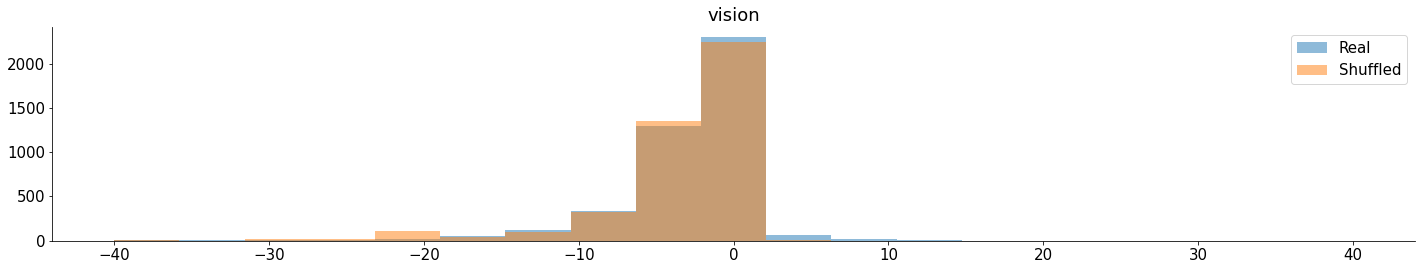

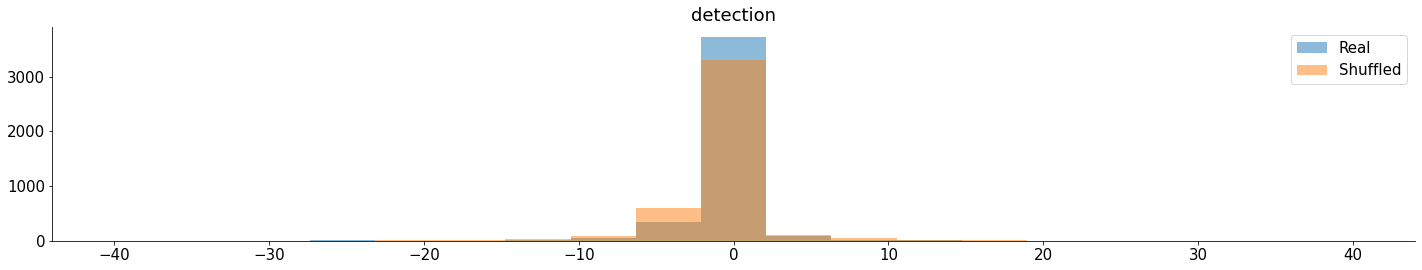

In [5]:
# calculate real and shuffled DEV distribution, and significance thresholds from the shuffled data, for vision, detection, and vision+detection

import matplotlib.pyplot as plt

regs = ['vision', 'detection']

all_shuffled_devs = dict()
all_real_devs = dict()

bins = np.linspace(-40, 40, 20)

# region = 'VISp'

# full_df = full_df[full_df['neuron_region'] == region]

for reg in regs:

  full_df[f'shuffled_dev_{reg}'] = 100*(full_df['mean_score_excl_none_shuffled'] - full_df[f'mean_score_excl_{reg}_shuffled'])

  full_df[f'real_dev_{reg}'] = 100*(full_df['mean_score_excl_none'] - full_df[f'mean_score_excl_{reg}'])

  plt.hist(full_df[f'real_dev_{reg}'], bins, alpha=0.5, label='Real')
  plt.hist(full_df[f'shuffled_dev_{reg}'], bins, alpha=0.5, label='Shuffled')
  plt.legend(loc='upper right')
  plt.title(reg)
  plt.show()


The explained variance threshold for vision is 1.804 percent.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


The explained variance threshold for detection is 12.83 percent.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


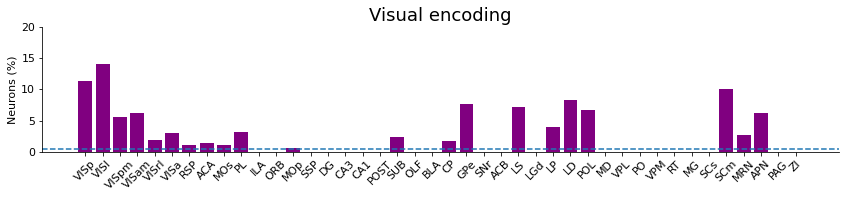

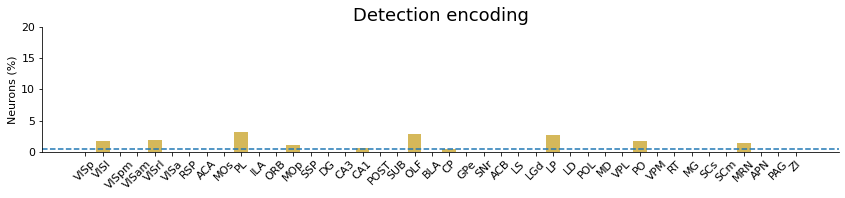

In [31]:
# get num neurons per brain region

unique_regions = pd.unique(full_df['neuron_region'])

counts = {**{region: 0 for region in unique_regions}}

for session in range(len(alldat)):
  dat = alldat[session]

  for region in unique_regions:

    counts[region] += np.sum(dat['brain_area']==region)


# find the percent of neurons above 95th percentile of shuffled

reg_titles = ['Visual encoding', 'Detection encoding']

colors = ['Purple', '#D5B85A']

thresh = 0.5

all_dev_thresholds = dict()

regions_ordered = ['VISp', 'VISl', 'VISpm', 'VISam', 'VISrl', 'VISa', 'RSP', 
                   'ACA', 'MOs', 'PL', 'ILA', 'ORB', 'MOp', 'SSP', 'DG', 'CA3', 
                   'CA1', 'POST', 'SUB', 'OLF', 'BLA', 'CP', 'GPe', 'SNr', 
                   'ACB', 'LS', 'LGd', 'LP', 'LD', 'POL', 'MD', 'VPL', 'PO', 
                   'VPM', 'RT', 'MG', 'SCs', 'SCm', 'MRN', 'APN', 'PAG', 'ZI']

# unique_regions = pd.unique(full_df['neuron_region'])
unique_regions = regions_ordered

all_percent_sig = pd.DataFrame(columns=unique_regions, index=regs)


for reg, reg_title, color in zip(regs, reg_titles, colors):

  all_dev_thresholds[reg] = np.percentile(full_df[f'shuffled_dev_{reg}'], 100-thresh)

  print(f'The explained variance threshold for {reg} is {all_dev_thresholds[reg]:.4} percent.')

  for unique_region in regions_ordered:

    region_df = full_df[full_df['neuron_region'] == unique_region][f'real_dev_{reg}']

    all_percent_sig.at[reg, unique_region] = 100*region_df[region_df > all_dev_thresholds[reg]].count()/region_df.count()
    #all_percent_sig.at[reg, unique_region] = 100*region_df[region_df > all_dev_thresholds[reg]].count()/counts[unique_region]

  # # make nice bar plots

  plt.figure(figsize=(12,3))
  plt.title(reg_title)
  plt.xticks(fontsize=11)
  plt.yticks(fontsize=11)
  plt.ylabel('Neurons (%)', fontsize=11)
  plt.bar(regions_ordered, all_percent_sig.loc[reg], color=color)
  ax = plt.gca();
  plt.ylim([0, 20])
  plt.axhline(thresh, linestyle='--')

  ax.set_xticklabels(labels = unique_regions, rotation=45);

  plt.savefig(f'{reg}.png', dpi=200)

In [ ]:

all_percent_sig

VISp     VISl    VISpm    VISam  ...      MRN   APN PAG ZI
vision     11.3636  14.0351  5.55556  6.21118  ...   2.7027  6.25   0  0
detection        0  1.75439        0        0  ...  1.35135     0   0  0

[2 rows x 42 columns]

In [ ]:
full_df[full_df['neuron_region'] == 'VISp'].sort_values('mean_score_excl_none').tail(20)

neuron_idx  ...  real_dev_detection
172         692  ...            0.175067
215         882  ...           -0.066366
112         676  ...           -1.902244
90          591  ...           -1.068374
104         656  ...           -1.081827
36          214  ...           -1.141503
31          599  ...            7.525069
32          183  ...            0.219308
110         429  ...           -0.561329
22          442  ...            3.469204
12          357  ...            0.380483
31          141  ...           -0.267299
33          184  ...            0.184922
170         677  ...            0.161564
24          100  ...            0.191742
26          120  ...            0.358488
34          190  ...            0.472242
82          627  ...            0.000000
58          437  ...            0.000000
54          604  ...            0.000000

[20 rows x 21 columns]